# Import Packages

In [1]:
import sys, os, pdb, glob
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from astropy.table import Table, join, MaskedColumn
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.modeling.models import Gaussian2D
from astropy.convolution.kernels import Model2DKernel
from astroquery.vizier import Vizier
import warnings
from astropy.logger import AstropyWarning
warnings.filterwarnings('ignore', category=AstropyWarning)

# Define Functions

In [2]:
def get_data(catalog, join_key='Name', join_type='inner'):

    """
    PURPOSE:    Get data from literature with Vizier

    INPUT:      catalog = ctalog name on Vizier (str)
                join_key = column header to join tables, if multiple (str; optional)
                join_type = way to join tables, if multiple (str; optional)

    OUTPUT:     t = data table (AstroPy Table)

    """

    ### GET FULL CATALOG (ALL COLUMNS, ALL ROWS)
    viz = Vizier(catalog=catalog, columns=['**'])
    viz.ROW_LIMIT = -1
    tv = viz.get_catalogs(catalog)

    ### IF MULTIPLE TABLES, JOIN THEN
    for i, val in enumerate(tv.keys()):
        if i == 0:
            t = tv[val]
        else:
            tt = tv[val]
            if join_key in tt.columns:
                t = join(t, tt, join_type=join_type, keys=join_key)

    return t


def readfits(file):

    """
    PURPOSE:    Read in FITS file and header info

    INPUT:      file = path to FITS file (str)

    OUTPUT:     data = image data (2x2 float arr)
                xcen, ycen = image center coordinates in pixels (float)
                xpix, ypix = image pixel width in deg/pix units (float)
                xcen_ra, xcen_de = image center coordinates in deg units (float)

    """

    hdulist = fits.open(file)
    data = hdulist[0].data[0, 0, :, :]
    head = hdulist[0].header
    hdulist.close()

    xcen = head['CRPIX1']
    ycen = head['CRPIX2']
    xpix = head['CDELT1']
    ypix = head['CDELT2']
    xcen_ra = head['CRVAL1']
    xcen_de = head['CRVAL2']

    return(data, xcen, ycen, xpix, ypix, xcen_ra, xcen_de)


def get_beam_kernel(bmin, bmaj, bpa, pscl):

    """
    PURPOSE:    Get beam kernel for plotting

    INPUT:      bmin, bmaj = beam minor & major axis in arcsec (float)
                bpa = beam position angle in degrees (float)
                pscl = image pixel scale of image (float)

    OUTPUT:     bkernel = beam kernel (float)
                xstd, ystd = beam standard deviaion in x, y directions (float)
                bpa = beam position angle (float)

    """

    ### BEAM STANDARD DEVIATION (NEEDED FOR Gaussian2D)
    xstd = (bmin / (2. * np.sqrt(2. * np.log(2.)))) / np.abs(pscl)
    ystd = (bmaj / (2. * np.sqrt(2. * np.log(2.)))) / np.abs(pscl)

    ### MAKE BEAM KERNEL
    ### DEFAULT KERNEL SIZE IS 8xWIDTH, MUST BE CENTERED ON [0,0]
    gauss_model = Gaussian2D(1, 0, 0, xstd, ystd, bpa)
    bkernel = Model2DKernel(gauss_model, x_size=int(xstd * 2), y_size=int(ystd * 2))

    return bkernel, xstd, ystd, bpa


def get_pos(ns, ncol):


    """
    PURPOSE:    Get position of subplot of image

    INPUT:      ns = total number of sources being plotted
                ncol = total number of columns being plotted

    OUTPUT:     plotpos = plot positions for images
                nx = notal number of columns in plot
                ny = total number of rows in plot

    """

    pxmin, pxmax = 0.01, 0.99
    pymin, pymax = 0.01, 0.99
    dx, dy = 0.005, 0.005

    nx, ny = int(ncol), int(math.ceil(ns / ncol))
    nplot = nx * ny

    plotpos = np.zeros((nplot, 4))
    sx = (pxmax - pxmin - (nx - 1) * dx) / nx
    sy = (pymax - pymin - (ny - 1) * dy) / ny
    iplot = 0

    for j in range(ny):
        py2 = pymax - j * (sy + dy)
        py1 = py2 - sy
        for i in range(nx):
            px1 = pxmin + i * (sx + dx)
            plotpos[iplot, :] = [px1, py1, sx, sy]
            iplot += 1

    return plotpos, nx, ny


def add_beam(bmj, bmn, bpa, sx, sy, bcol, ax):

    """
    PURPOSE:    Add beam to image

    INPUT:      bmj, bmn= beam major & minor axis in arcsec (float)
                bpa = beam position angle in degrees (float)
                sx, sy = location to plot beam (float)
                bcol = color of beam for plotting (str)
                ax = ax to plot beam (matplotlib ax)

    OUTPUT:     ax, but now with beam plotted (matplotlib ax) 

    """

    epa = 90. + bpa
    ell = Ellipse(xy=(sx, sy), width=bmj, height=bmn, angle=epa, edgecolor=bcol,
                  fc='None', linewidth=1.0, linestyle='solid')
    ax.add_patch(ell)

    return ax


def crop_stack(file, width_pix):

    hdulist = fits.open(file)
    img = hdulist[0].data
    hdulist.close()

    xcen, ycen = img.shape[0] / 2, img.shape[1] / 2
    img_crop = img[int(round(ycen - width_pix)):int(round(ycen + width_pix)),
                   int(round(xcen - width_pix)):int(round(xcen + width_pix))]

    return img_crop * 1e3

# Code

Load in Sigma Orionis data

In [3]:
T = get_data("J/AJ/153/240")

Index detections and non-detections

Note: Used 2.9 because online table decimal places cutoff to make < 3.0

In [4]:
ind_det = np.where(T['F1.33'] / T['e_F1.33'] >= 2.9)
ind_nd = np.where(T['F1.33'] / T['e_F1.33'] < 2.9)

Keep detections & order by decreasing flux

In [5]:
T = T[ind_det]
T.sort('F1.33')
T.reverse()

Create plot

NOTE: The order of the images has been adjusted to accurately reproduce the paper outputs.

Text(-0.9, 0.75, 'Stack #2 (12CO)')

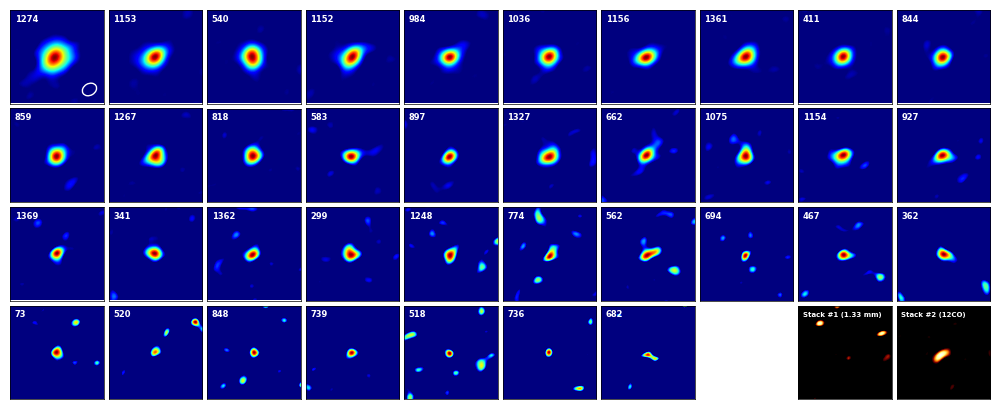

In [6]:
### SETUP PLOT
mpl.rc('xtick', labelsize=5)
mpl.rc('ytick', labelsize=5)
mpl.rc('xtick.major', size=1, pad=3, width=.5)
mpl.rc('ytick.major', size=1, pad=3, width=.5)
mpl.rc('axes', linewidth=0.5)
mpl.rc('lines', markersize=1)

### SWAPPING 520 & 848 SO ORDER MATCHES PAPER
T2 = T.copy()
t6 = T2[-6]
t5 = T2[-5]
T[-6] = t5
T[-5] = t6

### PLOT STAMPS
plotpos, nx, ny = get_pos(len(T), 10)
fig = plt.figure(figsize=(nx, ny))
for i, val in enumerate(T['__HHM2007_']):

    ### GET COORDINATES OF OBJECT FROM PAPER TABLE
    de_obj = str(T['DEJ2000'][i].split(' ')[0][0]) + str(T['DEJ2000'][i].split(' ')[0][1:]) + 'd' + str(T['DEJ2000'][i].split(' ')[1]) + 'm' + str(T['DEJ2000'][i].split(' ')[2]) + 's'
    ra_obj = str(T['RAJ2000'][i].split(' ')[0]) + 'h' + str(T['RAJ2000'][i].split(' ')[1]) + 'm' + str(T['RAJ2000'][i].split(' ')[2]) + 's'
    c_obj = SkyCoord(ra_obj, de_obj, frame='icrs')
    
    ### GET IMAGE FILE NAME
    File_Img = '../data/FITS/S_' + str(val) + '_cont.fits'
    if os.path.isfile(File_Img) is False:
        print('missing FITS file for ' + val)
        pdb.set_trace()

    ### LOAD IMAGE AND GET CENTER COORDINATES
    img, xcen_img, ycen_img, xpix_img, ypix_img, xcen_ra, ycen_de = readfits(File_Img)
    c_img = SkyCoord(xcen_ra, ycen_de, frame='icrs', unit='deg')
    
    ### CENTER IMAGE ON OBJECT LOCATION 
    hw_as = 1.0
    dra, ddec = c_img.spherical_offsets_to(c_obj)
    width_pix = int(round(hw_as / (ypix_img * 3600.0)))
    xctr = xcen_img + dra.value / xpix_img
    yctr = ycen_img + ddec.value / ypix_img

    ### CROP IMAGE AND PUT INTO mJy UNITS
    img = 1e3 * img[int(round(yctr - width_pix)):int(round(yctr + width_pix)),
                    int(round(xctr - width_pix)):int(round(xctr + width_pix))]

    ### REMOVE AXIS LABELS
    ax = fig.add_axes(plotpos[i, :])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    ### PLOT IMAGE
    ax.imshow(img, extent=[-hw_as, hw_as, -hw_as, hw_as], interpolation='bilinear', vmin=2*T['rms'][i], vmax=np.max(img), origin='lower', cmap='jet')
    ax.text(-hw_as * 0.9, hw_as * 0.75, str(val), fontsize=6, color='white', fontweight='bold')

    ### ADD BEAM TO FIRST IMAGE
    if i == 0:
        ax = add_beam(0.32, 0.25, -60.0, hw_as * 0.7, -hw_as * 0.7, 'white', ax)

### ADD CONTINUUM STACK
ax = fig.add_axes(plotpos[i + 2, :])
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
img = crop_stack('../output/stack_cont_CND.fits', width_pix)
ax.imshow(img, extent=[-1.0 * hw_as, 1.0 * hw_as, -1.0 * hw_as, 1.0 * hw_as], origin='lower', vmin=np.std(img) * 2., cmap='afmhot', interpolation='bilinear')
ax.text(-hw_as * 0.90, hw_as * 0.75, 'Stack #1 (1.33 mm)', fontsize=5, color='white', fontweight='bold')

### ADD 12CO STACKS
ax = fig.add_axes(plotpos[i + 3, :])
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
img = crop_stack('../output/stack_12CO_GND.fits', width_pix)
ax.imshow(img, extent=[-1.0 * hw_as, 1.0 * hw_as, -1.0 * hw_as, 1.0 * hw_as], origin='lower', vmin=np.std(img) * 2., cmap='afmhot', interpolation='bilinear')
ax.text(-hw_as * 0.90, hw_as * 0.75, 'Stack #2 (12CO)', fontsize=5, color='white', fontweight='bold')

Save plot

In [7]:
fig.savefig('../output/figure_02.png', bbox_inches='tight', dpi=900)
plt.close('all')